In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import seaborn as sns
from ExKMC.Tree import Tree as ExTree

sys.path.append("../main")
from tree import *
from rule_clustering import *
from utils import *
from experiments import Experiment
from grid import Grid

%load_ext autoreload
%autoreload 2

In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [3]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 12
})

colorblind_palette = sns.color_palette("colorblind", as_cmap=False)
cmap = ListedColormap(colorblind_palette)
subset_colors = [cmap(0), cmap(4), cmap(9)]
cmap_subset = ListedColormap(subset_colors)

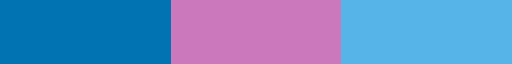

In [4]:
cmap_subset

## Simple Dataset

In [5]:
n = 2000
m = 2
k = 3

random_state = 170
data, labels = datasets.make_blobs(
    n_samples=n, cluster_std=[1.0, 2.5, 0.5], random_state=seed
)
data = preprocessing.MinMaxScaler().fit_transform(data)

Text(0, 0.5, 'y')

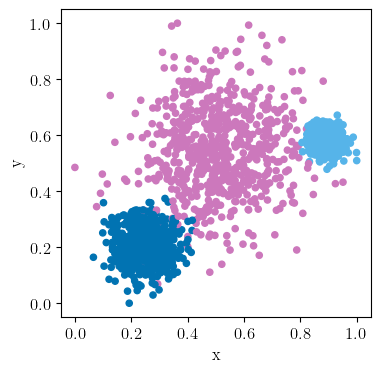

In [6]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = labels, cmap = cmap_subset, alpha = 1, s = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.savefig('figures/example_ground_truth.jpg', bbox_inches = 'tight', dpi = 300)

### Kmeans baseline

In [7]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(data)
kmeans_clustering = labels_to_clustering(kmeans.labels_)
cost = kmeans_cost(data, kmeans_clustering, kmeans.cluster_centers_)

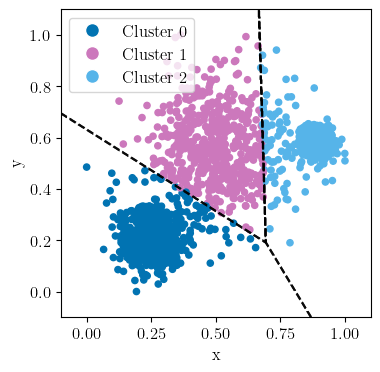

In [8]:
colorswitch = {0:2, 1:0, 2:1}
kmeans_labels_ = np.array([colorswitch[i] for i in kmeans.labels_])
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmeans_labels_, cmap = cmap_subset, s = 20)
plot_decision_boundaries(kmeans, data, ax = ax, resolution = 1000)

unique_labels = np.unique(kmeans.labels_)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {label}') for label in unique_labels]

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(handles=handles, loc = 'upper left')
#plt.savefig('figures/example_kmeans.jpg', bbox_inches = 'tight', dpi = 300)

### IMM Baseline

In [9]:
imm_tree = ExTree(k, max_leaves = 3)
imm_labels = imm_tree.fit_predict(data, kmeans)

Text(0, 0.5, 'y')

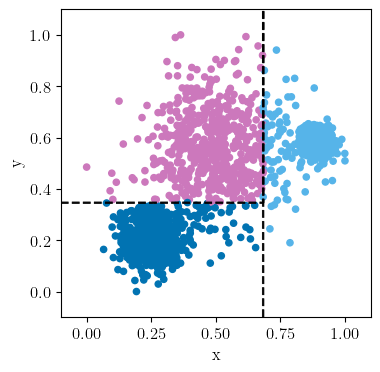

In [13]:
colorswitch = {0:2, 1:0, 2:1}
imm_labels_ = np.array([colorswitch[i] for i in imm_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = imm_labels_, cmap = cmap_subset, s = 20)
plot_decision_boundaries(imm_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.savefig('figures/example_imm.jpg', bbox_inches = 'tight', dpi = 300)

### Random Tree Baseline

In [14]:
# Revert the seed in case it has been advanced anywhere else:
np.random.seed(seed)

random_tree_cost = np.inf
random_tree = None
random_tree_labels = None

for i in range(10000):
    random_tree_ = RandomTree(max_leaf_nodes = k, min_points_leaf = 1)
    random_tree_.fit(kmeans.cluster_centers_)
    random_tree_labels_ = random_tree_.predict(data)
    random_tree_clustering_ = labels_to_clustering(random_tree_labels_)
    random_tree_centers_ = np.vstack([
                data[cluster, :].mean(axis=0) if len(cluster) > 0 else np.zeros(data.shape[1])
                for cluster in random_tree_clustering_
            ])
    #rcost = kmeans_cost(data, random_tree_clustering, kmeans.cluster_centers_)
    rcost = kmeans_cost(data, random_tree_clustering_, random_tree_centers_)
    if rcost < random_tree_cost:
        random_tree_cost = rcost
        random_tree = random_tree_
        random_tree_labels = random_tree_labels_

Text(0, 0.5, 'y')

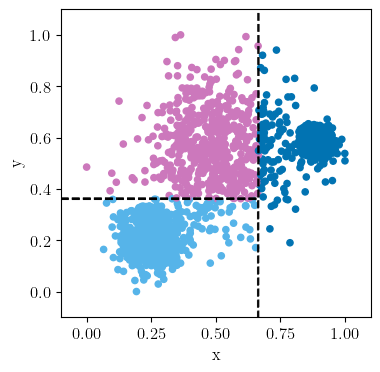

In [16]:
colorswitch = {0:2, 1:0, 2:1}
random_tree_labels_ = np.array([colorswitch[i] for i in random_tree_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = random_tree_labels_, cmap = cmap_subset, s = 20)
plot_decision_boundaries(random_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.savefig('figures/example_imm.jpg', bbox_inches = 'tight', dpi = 300)

# Creating Rule sets

### Grid Partition

In [32]:
cells = 4
grid = Grid(cells, [0,1])
grid.fit(data)
grid_labels = grid.predict(data)

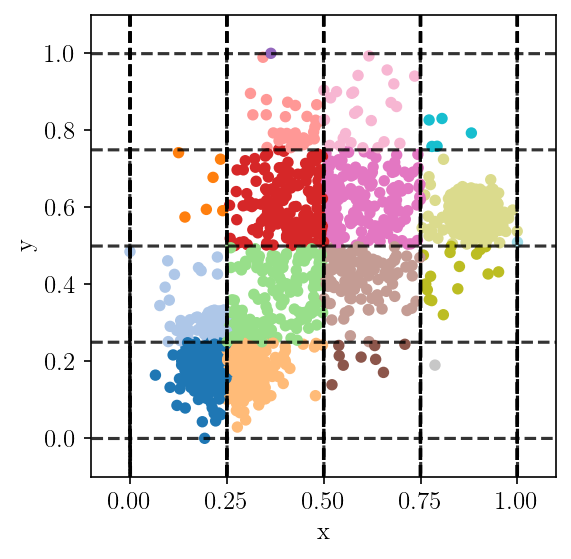

In [49]:
color_switch = {lab:i for i,lab in enumerate(np.unique(grid_labels))}
grid_labels_ = np.array([color_switch[i] for i in grid_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 150)


norm = mcolors.Normalize(vmin=np.min(grid_labels), vmax=np.max(grid_labels))
ax.scatter(data[:,0], data[:,1], c = grid_labels_, cmap = 'tab20', s = 20)
plot_decision_boundaries(grid, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.savefig('figures/examples/example_grid.png', bbox_inches = 'tight', dpi = 300)

### k-Means Tree Partition

In [52]:
kmeans_tree = UnsupervisedTree(splits = 'axis', max_leaf_nodes = 6, min_points_leaf = 1, norm = 2)
kmeans_tree.fit(data)
kmeans_tree_labels = kmeans_tree.predict(data)

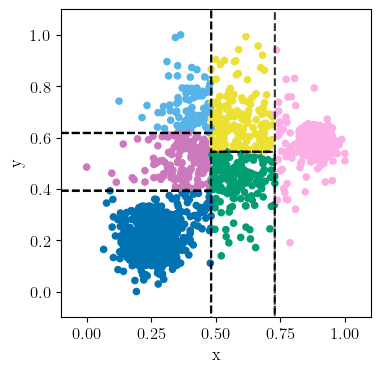

In [54]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmeans_tree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(kmeans_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.savefig('figures/examples/example_unsupervised_axis.png', bbox_inches = 'tight', dpi = 300)

In [17]:
#visualize_tree(kmeans_tree.root, feature_labels = ['x', 'y'])

### k-Medians Tree Partition

In [22]:
kmedians_tree = CentroidTree(max_leaf_nodes = 6, min_points_leaf = 1, norm = 1, center_init = 'manual', centers = kmeans.cluster_centers_)
kmedians_tree.fit(data)
kmedians_tree_labels = kmedians_tree.predict(data)

Text(0, 0.5, 'y')

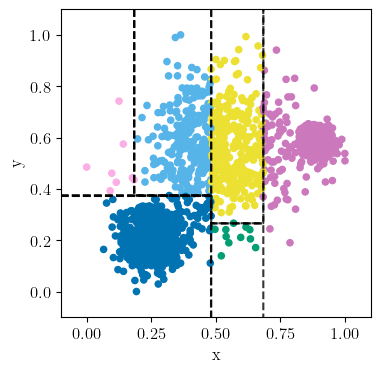

In [23]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmedians_tree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(kmedians_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

### ExKMC Tree

In [58]:
# ExKMC
ExKMC_tree = ExTree(k, max_leaves = 6, base_tree='NONE')
exkmc_labels = ExKMC_tree.fit_predict(data, kmeans)
exkmc_tree = ConvertExKMC(ExKMC_tree.tree, data)
exkmc_tree_labels = exkmc_tree.predict(data)

Text(0, 0.5, 'y')

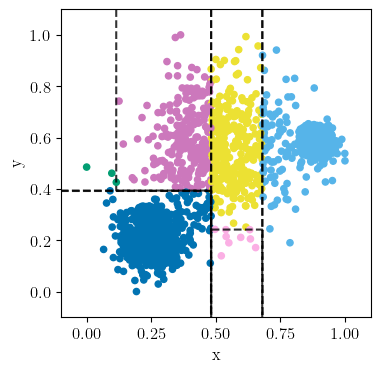

In [59]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = exkmc_tree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(exkmc_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

### CART

In [62]:
kmeans_extend = KMeans(n_clusters=k, random_state=seed).fit(data)
dtree = DecisionTreeClassifier(criterion='gini', max_leaf_nodes = 6)
dtree.fit(data, kmeans_extend.labels_)
kmeans_dtree = ConvertSklearn(dtree.tree_, data)
kmeans_dtree_labels = kmeans_dtree.predict(data)

Text(0, 0.5, 'y')

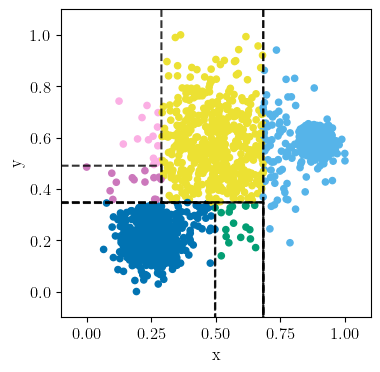

In [63]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmeans_dtree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(kmeans_dtree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

### Oblique Tree

In [55]:
obtree = CentroidTree(splits = 'oblique', max_leaf_nodes = 6, min_points_leaf = 1, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_)
obtree.fit(data)
obtree_labels = obtree.predict(data)

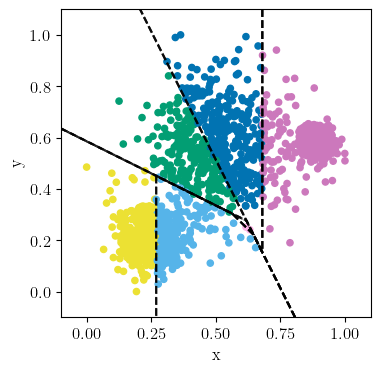

In [65]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = obtree.predict(data), cmap = cmap, s = 20)
plot_decision_boundaries(obtree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.savefig('figures/examples/example_centroid_oblique.png', bbox_inches = 'tight', dpi = 300)

# Rule Clustering

### 1. Rule k-Means

In [66]:
rules = kmeans_tree
rule_kmeans = KMeansRuleClustering(rules, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_)
rule_kmeans.fit(data)
rule_labels = rule_kmeans.labels
rule_kmeans_labels = rule_kmeans.predict(data)

In [75]:
rule_labels

array([nan, nan, nan, nan, nan, nan, nan,  1.,  1.,  2., nan, nan, nan,
        1.,  1.,  2.,  2.,  2., nan,  1.,  2.,  2.,  2., nan, nan,  0.,
        0.,  0.,  0., nan, nan, nan, nan,  0.])

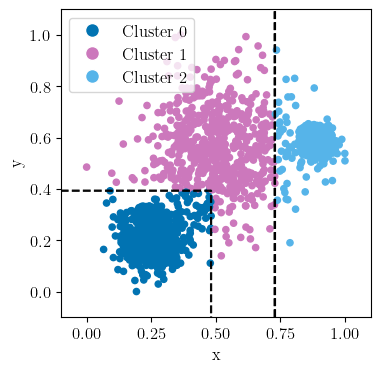

In [73]:
#plt.scatter(rule_kmeans.centers[:,0], rule_kmeans.centers[:,1], color = 'k', marker = 'x', s = 100)
colorswitch = {0:2, 1:0, 2:1}
rule_kmeans_labels_ = np.array([colorswitch[i] for i in rule_kmeans_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = rule_kmeans_labels_, cmap = cmap_subset, s = 20)
plot_decision_boundaries(rule_kmeans, data, ax = ax, resolution = 1000)

unique_labels = np.unique(rule_kmeans_labels)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {int(label)}') 
           if label != -1 else plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label='Unclustered') 
        for label in unique_labels]

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(handles=handles, loc = 'upper left')
plt.savefig('figures/examples/example_unsupervised.jpg', bbox_inches = 'tight', dpi = 300)

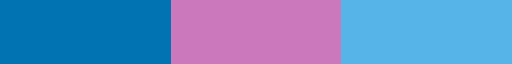

In [76]:
cmap_subset

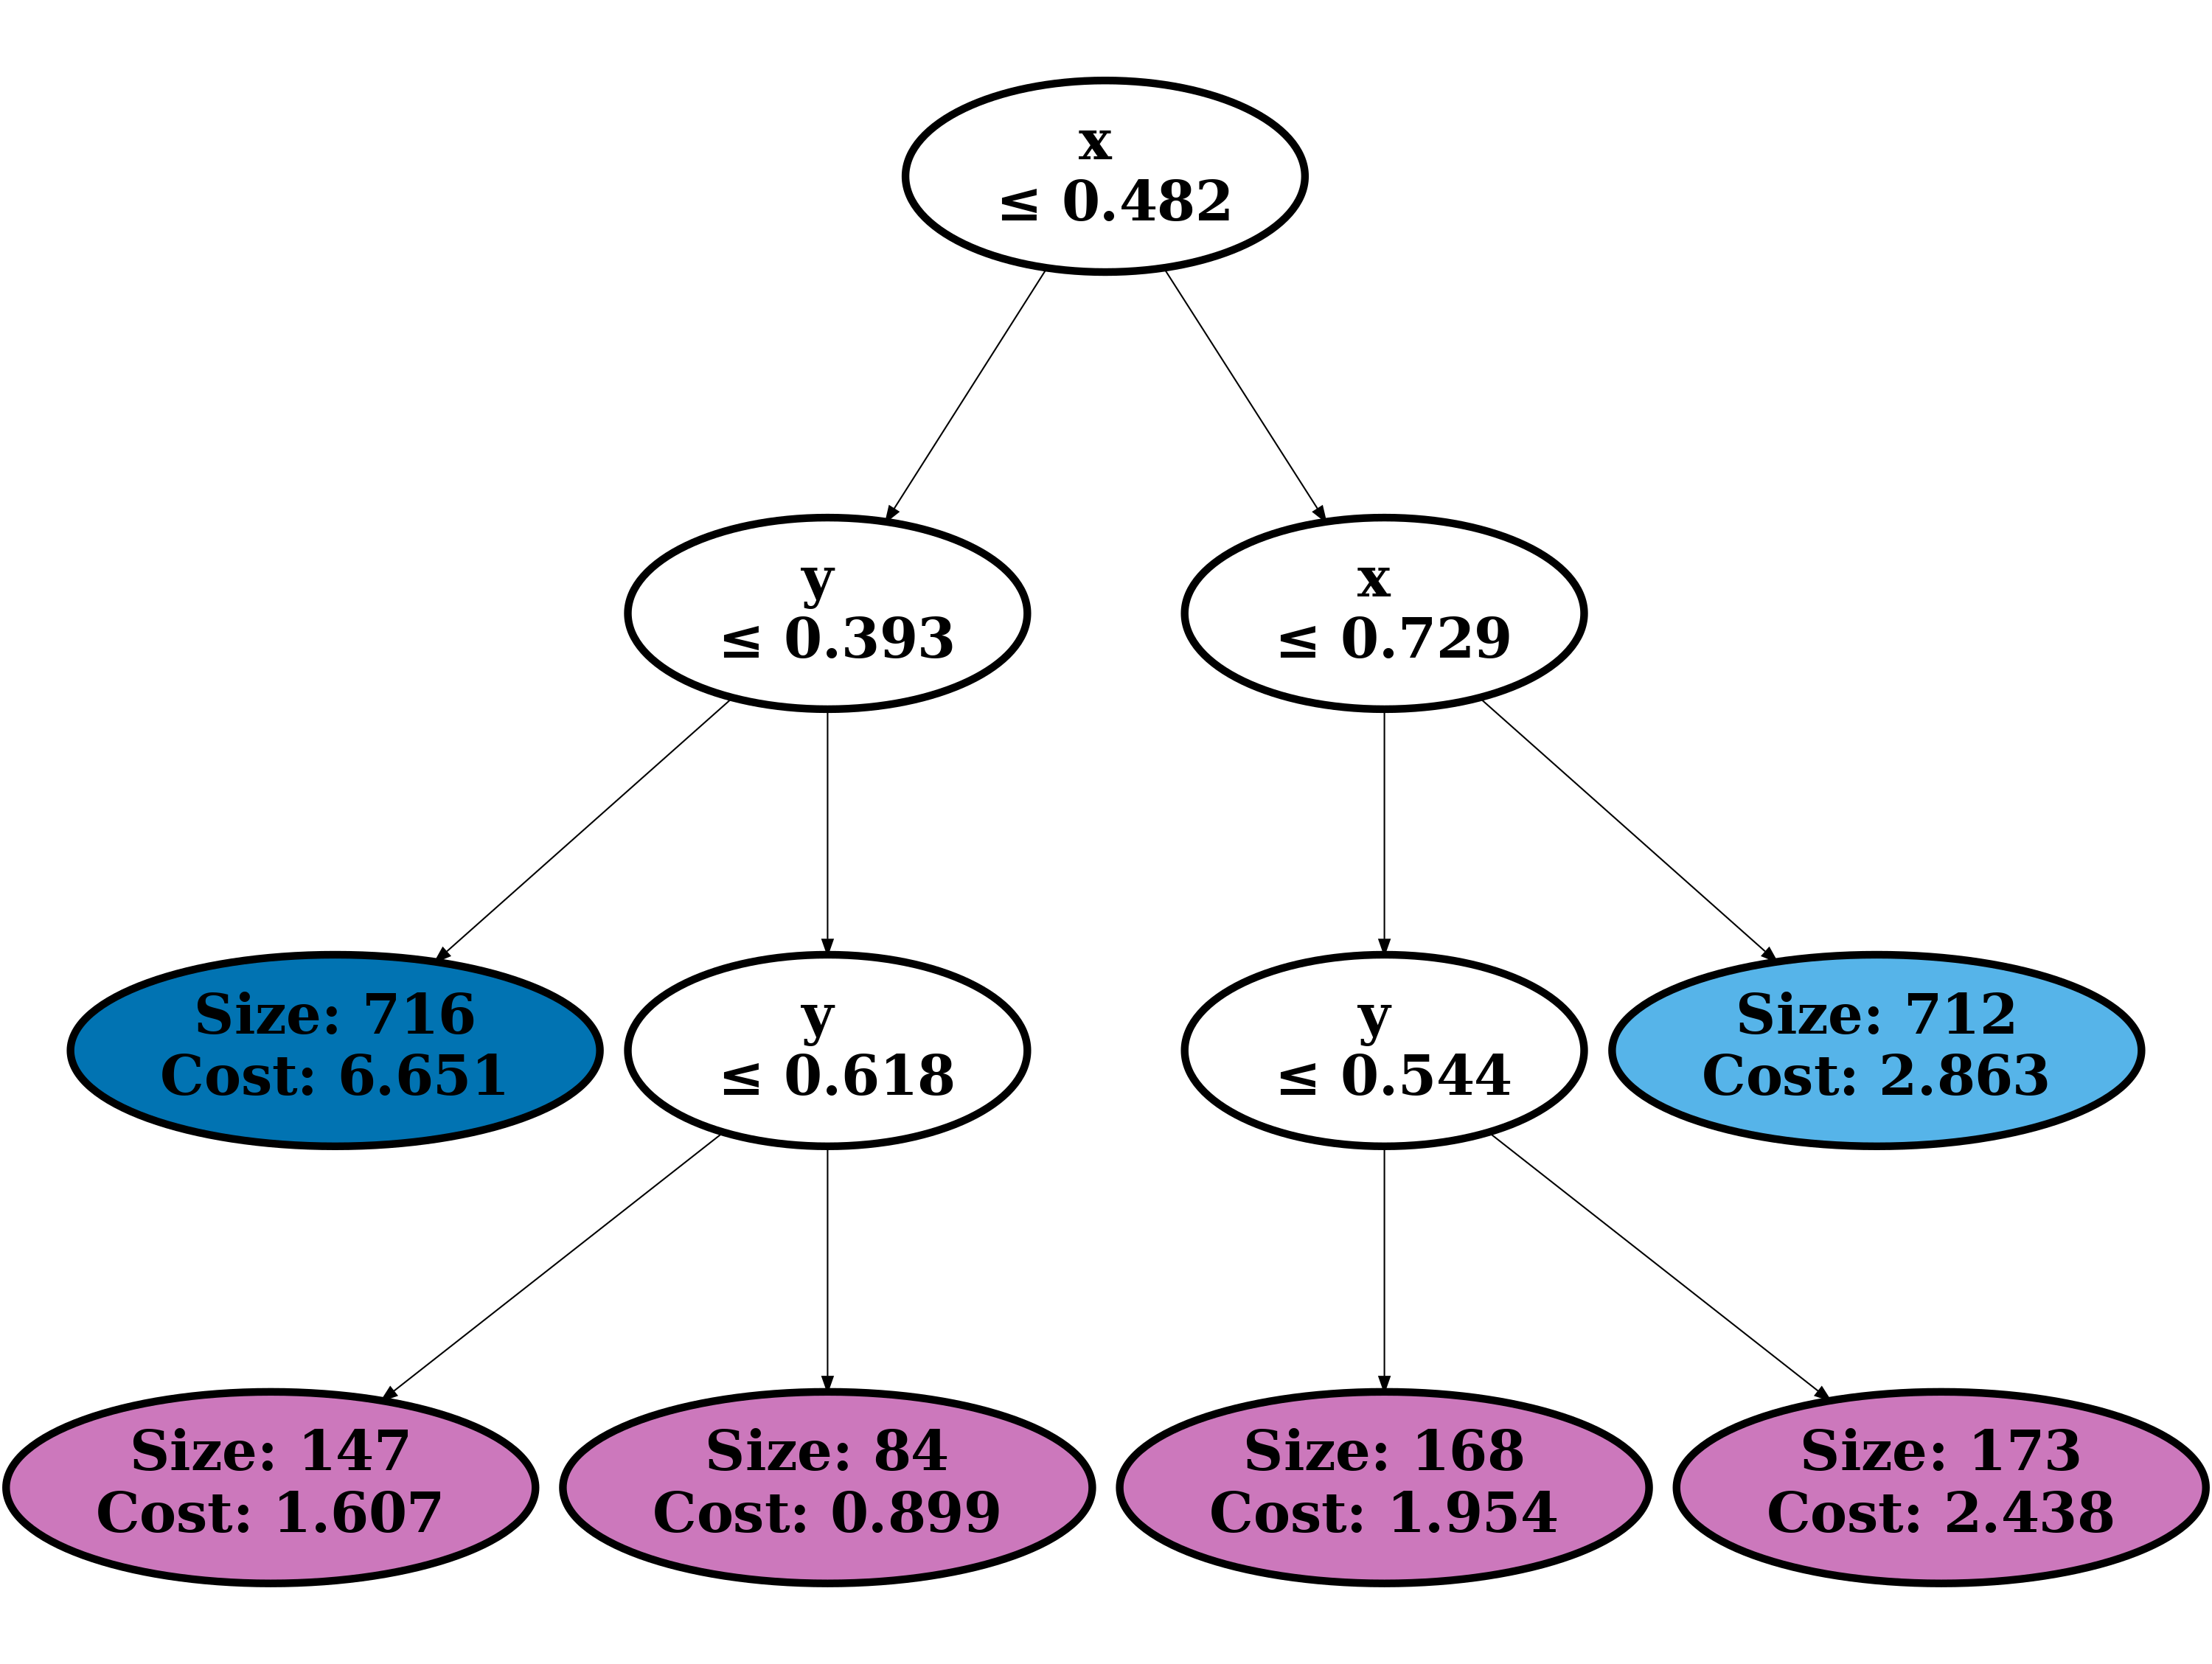

In [79]:
leaf_colors = {i:mcolors.rgb2hex(cmap_subset(int(colorswitch[rule_labels[i]]))) for i in range(6)}
visualize_tree(rules.root, output_file = 'figures/examples/unsupervised_axis_tree', feature_labels = ['x', 'y'], leaf_colors = leaf_colors)

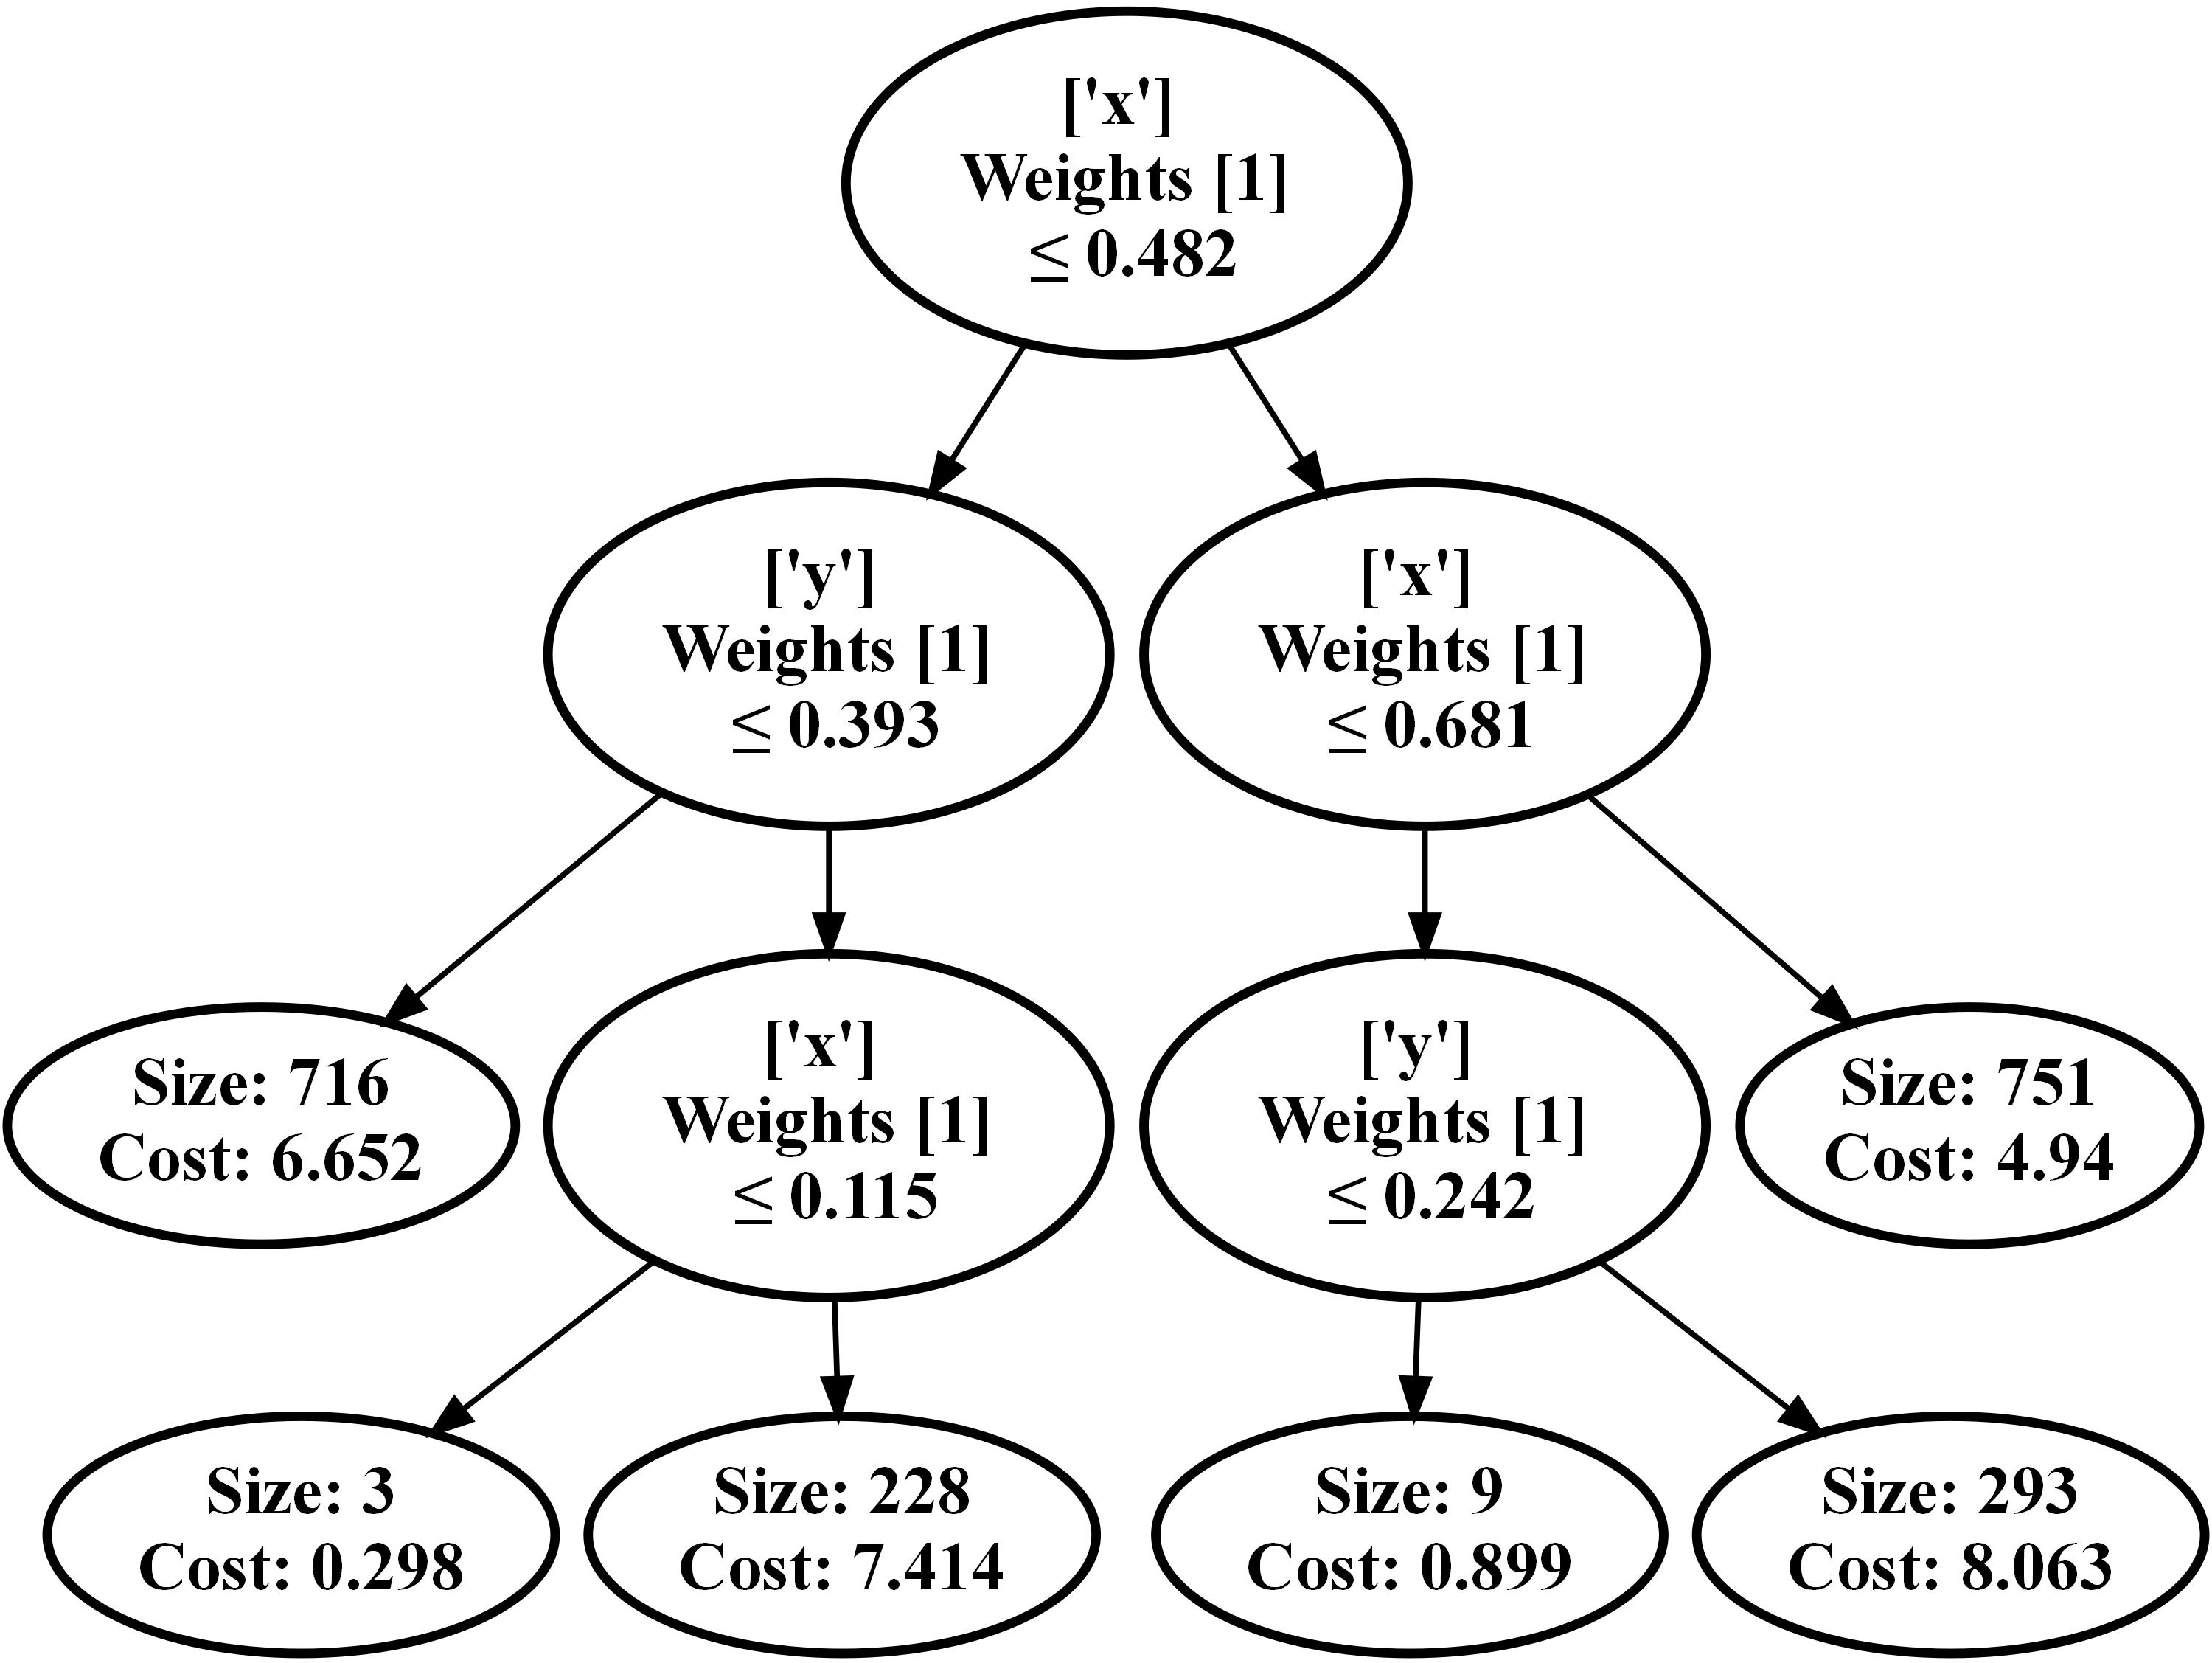

In [36]:
#rule_labels_ = [colorswitch[i] for i in rule_labels]
#leaf_colors = {leaf_node_labels[i]:mcolors.rgb2hex(cmap_subset(rule_labels_[i]), keep_alpha=True) for i in range(len(leaf_node_labels))}
visualize_tree(kmeans_tree.root, output_file = 'figures/spam.jpg', feature_labels = ['x', 'y'], leaf_colors = None, newline = False)

### 2. k-Medians

In [37]:
rules = kmedians_tree
rule_kmedians = KMediansRuleClustering(rules, k_clusters = k, init = 'random++', n_init = 10)
rule_kmedians.fit(data)
rule_kmedians_labels = rule_kmedians.predict(data)

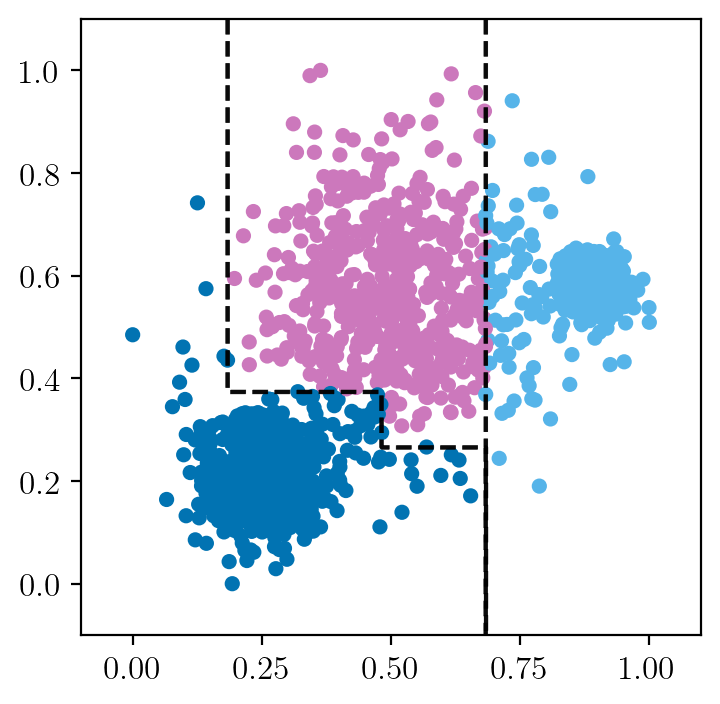

In [38]:
#plt.scatter(rule_kmeans.centers[:,0], rule_kmeans.centers[:,1], color = 'k', marker = 'x', s = 100)
colorswitch = {0:1, 1:0, 2:2}
rule_kmedians_labels_ = np.array([colorswitch[i] for i in rule_kmedians_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 200)
scatter = ax.scatter(data[:,0], data[:,1], c = rule_kmedians_labels, cmap = cmap_subset, s = 20)
plot_decision_boundaries(rule_kmedians, data, ax = ax, resolution = 1000)

# Cost Comparison

In [22]:
exp = Experiment(data = data, n_clusters = k, random_seed = seed, verbose = True)
exp.initialize()

Initializing k-means
Initializing IMM
Initializing Randomized IMM


In [23]:
exp.run_leaves_cost(min_leaves = k, max_leaves = 16, clusterer = KMeansRuleClustering)

Initializing trees...


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Number of leaves: 3


  7%|█████▉                                                                             | 1/14 [00:02<00:33,  2.56s/it]

Number of leaves: 4


 14%|███████████▊                                                                       | 2/14 [00:04<00:29,  2.45s/it]

Number of leaves: 5


 21%|█████████████████▊                                                                 | 3/14 [00:06<00:20,  1.84s/it]

Number of leaves: 6


 29%|███████████████████████▋                                                           | 4/14 [00:07<00:17,  1.78s/it]

Number of leaves: 7


 36%|█████████████████████████████▋                                                     | 5/14 [00:08<00:13,  1.47s/it]

Number of leaves: 8


 43%|███████████████████████████████████▌                                               | 6/14 [00:09<00:11,  1.39s/it]

Number of leaves: 9


 50%|█████████████████████████████████████████▌                                         | 7/14 [00:10<00:08,  1.27s/it]

Number of leaves: 10


 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:12<00:07,  1.22s/it]

Number of leaves: 11


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:12<00:05,  1.13s/it]

Number of leaves: 12


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:13<00:04,  1.09s/it]

Number of leaves: 13


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:15<00:03,  1.19s/it]

Number of leaves: 14


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [00:16<00:02,  1.06s/it]

Number of leaves: 15


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:16<00:00,  1.01it/s]

Number of leaves: 16


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00,  1.27s/it]


In [25]:
exp.run_depths_cost(min_depth = 2, max_depth = 8, max_leaves = 16, clusterer = KMeansRuleClustering)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Depth: 2


 14%|████████████                                                                        | 1/7 [00:18<01:53, 18.90s/it]

Depth: 3


 29%|████████████████████████                                                            | 2/7 [00:43<01:50, 22.20s/it]

Depth: 4


 43%|████████████████████████████████████                                                | 3/7 [01:17<01:50, 27.61s/it]

Depth: 5


 57%|████████████████████████████████████████████████                                    | 4/7 [01:48<01:26, 28.79s/it]

Depth: 6


 71%|████████████████████████████████████████████████████████████                        | 5/7 [02:25<01:04, 32.00s/it]

Depth: 7


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [03:01<00:33, 33.18s/it]

Depth: 8


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:31<00:00, 30.24s/it]


Text(0, 0.5, 'Cost')

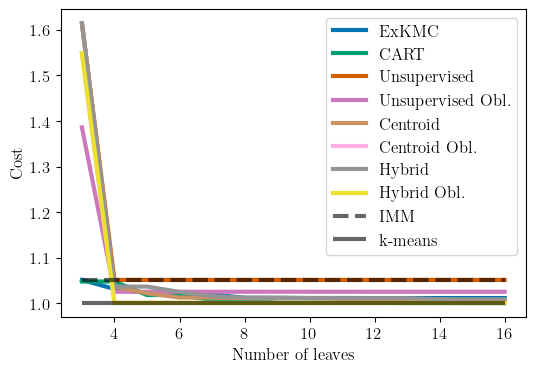

In [35]:
fig,ax = plt.subplots(figsize = (6,4))

leaves_cost_df = exp.leaves_cost_df
cost = leaves_cost_df['k-means'].iloc[0]
imm_cost = leaves_cost_df['IMM'].iloc[0]
random_imm_cost = leaves_cost_df['RandomIMM'].iloc[0]
leaves = leaves_cost_df.index 

ax.plot(leaves, np.array(leaves_cost_df['ExKMC'])/cost, linewidth = 3, label = 'ExKMC', c = cmap(0))
ax.plot(leaves, np.array(leaves_cost_df['CART'])/cost, linewidth = 3, label = 'CART', c = cmap(2))
ax.plot(leaves, np.array(leaves_cost_df['Unsupervised'])/cost, linewidth = 3, label = 'Unsupervised', c = cmap(3))
ax.plot(leaves, np.array(leaves_cost_df['Unsupervised Obl.'])/cost, linewidth = 3, label = 'Unsupervised Obl.', c = cmap(4))
ax.plot(leaves, np.array(leaves_cost_df['Centroid'])/cost, linewidth = 3, label = 'Centroid', c = cmap(5))
ax.plot(leaves, np.array(leaves_cost_df['Centroid Obl.'])/cost, linewidth = 3, label = 'Centroid Obl.', c = cmap(6))
ax.plot(leaves, np.array(leaves_cost_df['Hybrid'])/cost, linewidth = 3, label = 'Hybrid', c = cmap(7))
ax.plot(leaves, np.array(leaves_cost_df['Hybrid Obl.'])/cost, linewidth = 3, label = 'Hybrid Obl.', c = cmap(8))

#ax.hlines(random_imm_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = 'dotted', label = 'RandomIMM', linewidth = 3, alpha = 0.6)
ax.hlines(imm_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'IMM', linewidth = 3, alpha = 0.6)
ax.hlines(cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '-', label = 'k-means', linewidth = 3, alpha = 0.6)

plt.legend(loc = 'upper right')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Cost')

Text(0, 0.5, 'Depth')

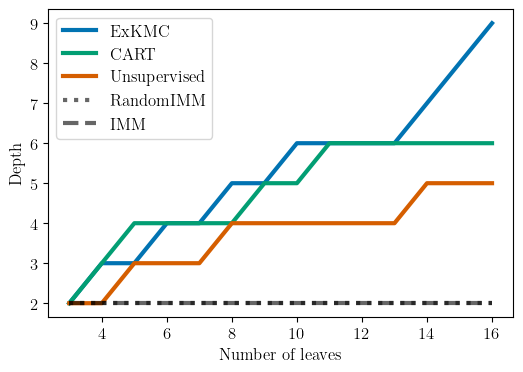

In [41]:
fig,ax = plt.subplots(figsize = (6,4))

data_df = exp.leaves_depth_df
imm_depth = data_df['IMM'].iloc[0]
random_imm_depth = data_df['RandomIMM'].iloc[0]
leaves = data_df.index 

ax.plot(leaves, np.array(data_df['ExKMC']), linewidth = 3, label = 'ExKMC', c = cmap(0))
ax.plot(leaves, np.array(data_df['CART']), linewidth = 3, label = 'CART', c = cmap(2))
ax.plot(leaves, np.array(data_df['Unsupervised']), linewidth = 3, label = 'Unsupervised', c = cmap(3))
ax.plot(leaves, np.array(data_df['Unsupervised Obl.']), linewidth = 3, label = 'Unsupervised Obl.', c = cmap(4))
ax.plot(leaves, np.array(data_df['Centroid']), linewidth = 3, label = 'Centroid', c = cmap(5))
ax.plot(leaves, np.array(data_df['Centroid Obl.']), linewidth = 3, label = 'Centroid Obl.', c = cmap(6))
ax.plot(leaves, np.array(data_df['Hybrid']), linewidth = 3, label = 'Hybrid', c = cmap(7))
ax.plot(leaves, np.array(data_df['Hybrid Obl.']), linewidth = 3, label = 'Hybrid Obl.', c = cmap(8))

ax.hlines(random_imm_depth, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = 'dotted', label = 'RandomIMM', linewidth = 3, alpha = 0.6)
ax.hlines(imm_depth, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'IMM', linewidth = 3, alpha = 0.6)

plt.legend(loc = 'upper left')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Depth')

Text(0, 0.5, 'Clustering Iterations')

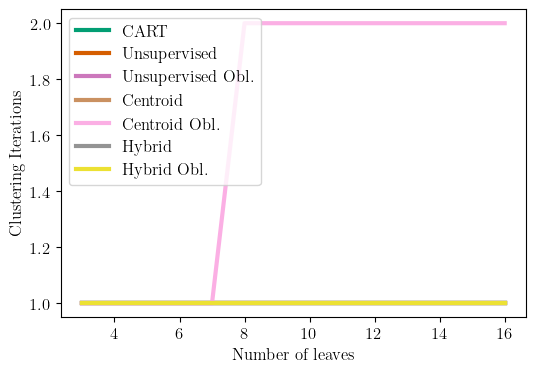

In [42]:
fig,ax = plt.subplots(figsize = (6,4))

data_df = exp.leaves_iteration_df
leaves = data_df.index 

ax.plot(leaves, np.array(data_df['CART']), linewidth = 3, label = 'CART', c = cmap(2))
ax.plot(leaves, np.array(data_df['Unsupervised']), linewidth = 3, label = 'Unsupervised', c = cmap(3))
ax.plot(leaves, np.array(data_df['Unsupervised Obl.']), linewidth = 3, label = 'Unsupervised Obl.', c = cmap(4))
ax.plot(leaves, np.array(data_df['Centroid']), linewidth = 3, label = 'Centroid', c = cmap(5))
ax.plot(leaves, np.array(data_df['Centroid Obl.']), linewidth = 3, label = 'Centroid Obl.', c = cmap(6))
ax.plot(leaves, np.array(data_df['Hybrid']), linewidth = 3, label = 'Hybrid', c = cmap(7))
ax.plot(leaves, np.array(data_df['Hybrid Obl.']), linewidth = 3, label = 'Hybrid Obl.', c = cmap(8))

plt.legend(loc = 'upper left')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Clustering Iterations')

Text(0, 0.5, 'Cost')

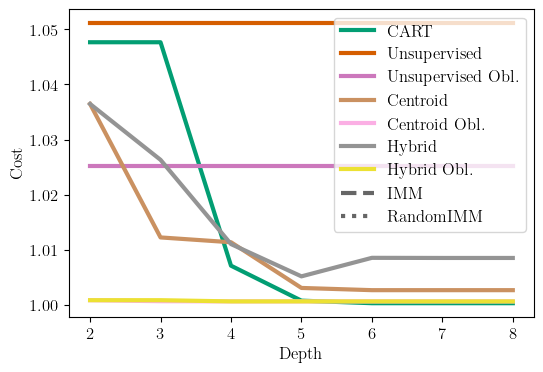

In [48]:
fig,ax = plt.subplots(figsize = (6,4))

depths_cost_df = exp.depths_cost_df
imm_cost = leaves_cost_df['IMM'].iloc[0]
random_imm_cost = leaves_cost_df['RandomIMM'].iloc[0]
depths = depths_cost_df.index 

ax.plot(depths, np.array(depths_cost_df['CART'])/cost, linewidth = 3, label = 'CART', c = cmap(2))
ax.plot(depths, np.array(depths_cost_df['Unsupervised'])/cost, linewidth = 3, label = 'Unsupervised', c = cmap(3))
ax.plot(depths, np.array(depths_cost_df['Unsupervised Obl.'])/cost, linewidth = 3, label = 'Unsupervised Obl.', c = cmap(4))
ax.plot(depths, np.array(depths_cost_df['Centroid'])/cost, linewidth = 3, label = 'Centroid', c = cmap(5))
ax.plot(depths, np.array(depths_cost_df['Centroid Obl.'])/cost, linewidth = 3, label = 'Centroid Obl.', c = cmap(6))
ax.plot(depths, np.array(depths_cost_df['Hybrid'])/cost, linewidth = 3, label = 'Hybrid', c = cmap(7))
ax.plot(depths, np.array(depths_cost_df['Hybrid Obl.'])/cost, linewidth = 3, label = 'Hybrid Obl.', c = cmap(8))

ax.plot(depths, np.array(depths_cost_df['IMM'])/cost, linewidth = 3, label = 'IMM', c = 'k', linestyle = '--', alpha = 0.6)
ax.plot(depths, np.array(depths_cost_df['RandomIMM'])/cost, linewidth = 3, label = 'RandomIMM', c = 'k', linestyle = 'dotted', alpha = 0.6)

plt.legend(loc = 'upper right')
ax.set_xlabel('Depth')
ax.set_ylabel('Cost')

# Dataset Demonstration

In [77]:
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), np.zeros(n_samples)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

dataset_list = [noisy_circles, noisy_moons, blobs, aniso, varied, no_structure]

C:\Users\kq146\AppData\Local\Temp\ipykernel_28892\3927023097.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


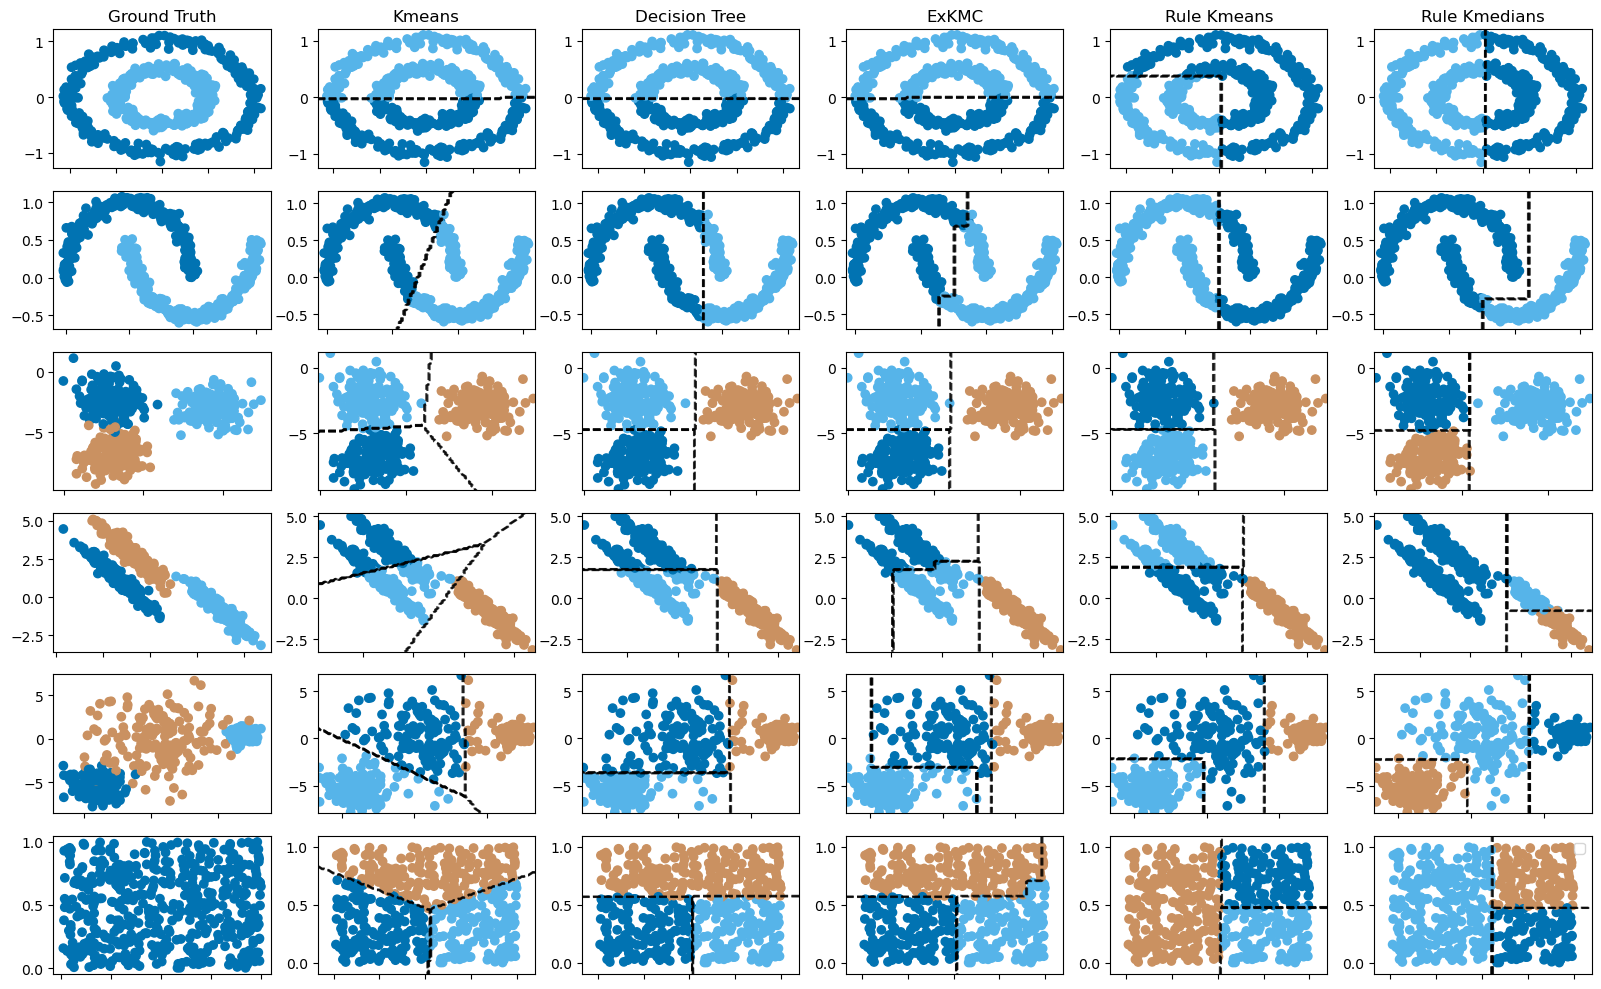

In [78]:
# Cluster and display Results
fig,axes = plt.subplots(6,6, figsize = (16,10))

# For each of the datasets do clusters
for d in range(len(dataset_list)):
    # Set titles
    if d == 0:
        axes[d,0].set_title('Ground Truth')
        axes[d,1].set_title('Kmeans')
        axes[d,2].set_title('Decision Tree')
        axes[d,3].set_title('ExKMC')
        axes[d,4].set_title('Rule Kmeans')
        axes[d,5].set_title('Rule Kmedians')
        #axes[d,5].set_title('Rule Agglomerative')
    
    X,y = dataset_list[d]

    # determine the number of clusters
    if np.sum(y) == 0:
        n_clusters = 3
    else:
        n_clusters = len(np.unique(y))

    # Baseline:
    axes[d,0].scatter(X[:,0], X[:,1], c = y, cmap = cmap)
    axes[d,0].set_xticklabels([])

    # Kmeans:
    kmeans = KMeans(n_clusters=n_clusters, random_state=39, n_init="auto").fit(X)
    axes[d,1].scatter(X[:,0], X[:,1], c = kmeans.labels_, cmap = cmap)
    plot_decision_boundaries(kmeans, X, ax = axes[d,1])
    axes[d,1].set_xticklabels([])

    # Decision tree
    tree = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = n_clusters).fit(X, kmeans.labels_)
    tree_labels = tree.predict(X)
    axes[d,2].scatter(X[:,0], X[:,1], c = tree_labels, cmap = cmap)
    plot_decision_boundaries(tree, X, ax = axes[d,2])
    axes[d,2].set_xticklabels([])

    # ExKMC
    ExKMC_tree = ExTree(n_clusters, max_leaves = 6)
    exkmc_labels = ExKMC_tree.fit_predict(X, kmeans)
    axes[d,3].scatter(X[:,0], X[:,1], c = exkmc_labels, cmap = cmap)
    plot_decision_boundaries(ExKMC_tree, X, ax = axes[d,3])
    axes[d,3].set_xticklabels([])

    # Rule K-means
    kmeans_tree = KMeansTree(max_leaf_nodes = 6, min_points_leaf = 1)
    kmeans_tree.fit(X)
    kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)
    rule_kmeans = KMeansRuleClustering(kmeans_rules, k_clusters = n_clusters, init = 'k-means', max_iterations = 500)
    rule_kmeans.fit(X)
    rule_kmeans_labels = rule_kmeans.predict(X)
    
    axes[d,4].scatter(X[:,0], X[:,1], c = rule_kmeans_labels, cmap = cmap)
    plot_decision_boundaries(rule_kmeans, X, ax = axes[d,4])
    axes[d,4].set_xticklabels([])

    # Rule k-Medians
    kmedians_tree = KMediansTree(max_leaf_nodes = 6, min_points_leaf = 1)
    kmedians_tree.fit(X)
    kmedians_rules = tree_to_rules().traverse(kmedians_tree.root)
    rule_kmedians = KMediansRuleClustering(kmedians_rules, k_clusters = n_clusters, init = 'k-medians', max_iterations = 500)
    rule_kmedians.fit(X)
    rule_kmedians_labels = rule_kmedians.predict(X)
    axes[d,5].scatter(X[:,0], X[:,1], c = rule_kmedians_labels, cmap = cmap)
    plot_decision_boundaries(rule_kmedians, X, ax = axes[d,5])
    axes[d,5].set_xticklabels([])

    # Rule Agglomerative:
    '''
    D_single = compute_distance_matrix(X, kmeans_rules, rule_single_linkage_distance)
    AggCluster = AgglomerativeRuleClustering(kmeans_rules, k_clusters = 4, linkage = 'single')
    AggCluster.fit(X, D_single)
    AggCluster_labels = AggCluster.predict(X)
    
    axes[d,5].scatter(X[:,0], X[:,1], c = AggCluster_labels)
    plot_decision_boundaries(AggCluster, X, ax = axes[d,5])
    unique_labels = np.unique(AggCluster_labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label='Unclustered') for label in unique_labels if label == -1]
    axes[d,5].legend(handles=handles)
    axes[d,5].set_xticklabels([])
    '''
        

# Loop through each subplot
for i, ax in enumerate(axes.flat):
    #ax.plot(x, y)
    
    # Hide x-axis labels for all subplots except those in the last row
    if i < 5 * 5:  # If the subplot is not in the last row
        ax.set_xticklabels([])

# Adjust the layout
plt.tight_layout()
plt.legend()